In [1]:
! nvidia-smi

Tue May  2 18:19:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    42W /  70W |   8719MiB / 15360MiB |     91%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
PROJECT_NAME = 'SplitNet__Cameraman'
device = 'cuda:1'

# Init

In [3]:
import lovely_tensors as lt
lt.monkey_patch()

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

## Siren Code

In [5]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Ubermodel Code

In [45]:
import rff

class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32, is_first=False, bias=True):
        super().__init__()
        
        self.in_features = input_dim
        self.linear = nn.Linear(input_dim, h*4, bias=bias)
        self.h = h
        self.omega_0 = 1.
        self.is_first = is_first
        # self.init_weights()
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * (o[..., 2*h:3*h]*self.omega_0).sin() * (o[..., 3*h:4*h]*self.omega_0).cos()
        return o
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
                
class UberLayerBatchNorm(nn.Module):
    def __init__(self, input_dim, h=32, is_first=False, bias=True):
        super().__init__()
        
        self.in_features = input_dim
        self.batchnorm = nn.BatchNorm1d(h*4)
        self.linear = nn.Linear(input_dim, h*4, bias=bias)
        self.h = h
        self.omega_0 = 1.
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = self.batchnorm(o)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * (o[..., 2*h:3*h]*self.omega_0).sin() * (o[..., 3*h:4*h]*self.omega_0).cos()
        return o
    
    
class UberNetWithEncodingBanana(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = [UberLayerBatchNorm(encoded_size*2, hidden_features, is_first=True),
                    UberLayerBatchNorm(hidden_features, hidden_features)]
  
        if outermost_linear:
            self.net += [nn.Linear(hidden_features, out_features)]
        else:
            self.net += [UberLayerBatchNorm(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
        
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True).squeeze() # allows to take derivative w.r.t. input
        x = self.encoding(coords)
        x = self.net[0](x)
        x = self.net[1](x)
        x = self.net[2](x)
        output = x.unsqueeze(0)
        return output, coords 

## Util

In [7]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [8]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [9]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

In [10]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [11]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [13]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

# Train pipeline

In [15]:
def tensor2pil(t):
    return Image.fromarray((t.detach().cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

In [16]:
def train(model, cfg):
    device = cfg['device']
    model.to(device)
    
    losses = []

    total_steps = cfg['total_steps']
    steps_til_summary = cfg['steps_til_summary']

    if cfg.get('use_wandb'):
        import wandb
        wandb.init(project=cfg['project'], name=cfg['experiment_name'], config=cfg)
        
    total_params = count_parameters(model)

    if cfg.get('use_wandb'):
        wandb.log({'total_params': total_params})

    optim = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())

    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    for step in range(total_steps):
        model_output, coords = model(model_input)
        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse

        if cfg.get('use_wandb'):
            log_dic = {'step': step, 'mse': mse.item(), 'psnr': psnr.item()}
            wandb.log(log_dic)
            
            if step < 3:
                print(step, log_dic)

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            # img_grad_tensor = gradient(model_output, coords)
            # img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output)
            # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            # img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = tensor2pil(torch.cat([img], dim=1))
            plt.imshow(colage)
            plt.show()

            if cfg.get('use_wandb'):
                wandb.log({'step': step, 'image': wandb.Image(colage)})

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    wandb.finish()

# UberModel Train Run

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| net.0.batchnorm.weight |    512     |
|  net.0.batchnorm.bias  |    512     |
|  net.0.linear.weight   |   65536    |
|   net.0.linear.bias    |    512     |
| net.1.batchnorm.weight |    512     |
|  net.1.batchnorm.bias  |    512     |
|  net.1.linear.weight   |   65536    |
|   net.1.linear.bias    |    512     |
| net.2.batchnorm.weight |     4      |
|  net.2.batchnorm.bias  |     4      |
|  net.2.linear.weight   |    512     |
|   net.2.linear.bias    |     4      |
+------------------------+------------+
Total Trainable Params: 134668 type <class '__main__.UberNetWithEncodingBanana'>


mse,█▄▁
psnr,▁▄█
step,▁▁▅█
total_params,▁
mse,0.34593
psnr,4.61013
step,2
total_params,135436


+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| net.0.batchnorm.weight |    512     |
|  net.0.batchnorm.bias  |    512     |
|  net.0.linear.weight   |   65536    |
|   net.0.linear.bias    |    512     |
| net.1.batchnorm.weight |    512     |
|  net.1.batchnorm.bias  |    512     |
|  net.1.linear.weight   |   65536    |
|   net.1.linear.bias    |    512     |
| net.2.batchnorm.weight |     4      |
|  net.2.batchnorm.bias  |     4      |
|  net.2.linear.weight   |    512     |
|   net.2.linear.bias    |     4      |
+------------------------+------------+
Total Trainable Params: 134668 type <class '__main__.UberNetWithEncodingBanana'>
0 {'step': 0, 'mse': 0.35218513011932373, 'psnr': 4.532289981842041, '_timestamp': 1683054457, '_runtime': 3}
Step 0, Total loss 0.352185


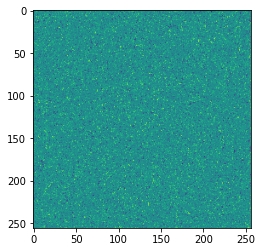

1 {'step': 1, 'mse': 0.34905219078063965, 'psnr': 4.571096420288086, '_timestamp': 1683054457, '_runtime': 3}
2 {'step': 2, 'mse': 0.34594619274139404, 'psnr': 4.609914302825928, '_timestamp': 1683054457, '_runtime': 3}
Step 1000, Total loss 0.034987


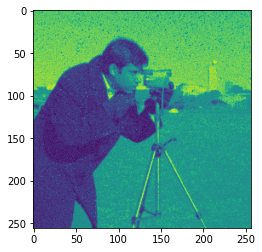

Step 2000, Total loss 0.017633


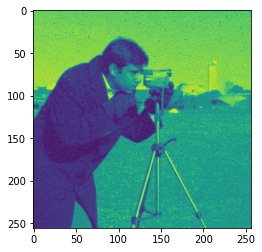

Step 3000, Total loss 0.010424


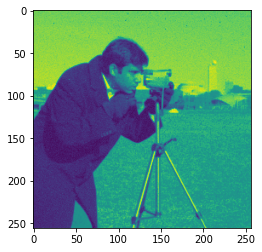

Step 4000, Total loss 0.006427


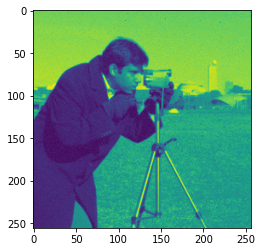

mse,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
psnr,▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_params,▁
mse,0.004
psnr,23.98465
step,4999
total_params,134668


In [46]:
cfg = {}
cfg['device'] = device
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 5_000
cfg['steps_til_summary'] = 1000
cfg['project'] = PROJECT_NAME
cfg['experiment_name'] = '00_ubermodel_128-fixed-batchnorm'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': False,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncodingBanana(**cfg['model_kwargs'])

# c = 1 / 128
# torch.nn.init.uniform_(model.net[-1].linear.weight, -c, c)
# display(model.net[-1].linear.weight.data.plt)

count_parameters(model)
train(model, cfg)

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [30]:
class UberNetWithEncodingBanana(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = [UberLayer(encoded_size*2, hidden_features, is_first=True),
                    UberLayer(hidden_features, hidden_features)]
  
        if outermost_linear:
            self.net += [nn.Linear(hidden_features, out_features)]
        else:
            self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
        
        self.batchnorm_1layer = nn.BatchNorm1d(128)
        self.batchnorm_2layer = nn.BatchNorm1d(128)
        self.batchnorm_3layer = nn.BatchNorm1d(128)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True).squeeze() # allows to take derivative w.r.t. input
        x = self.encoding(coords)
        x = self.batchnorm_1layer(x)
        x = self.net[0](x)
        x = self.batchnorm_2layer(x)
        x = self.net[1](x)
        x = self.batchnorm_3layer(x)
        x = self.net[2](x)
        output = x.unsqueeze(0)
        return output, coords 

In [31]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

In [32]:
model = UberNetWithEncodingBanana(**cfg['model_kwargs']).to(device)
self=model

In [37]:
with torch.inference_mode():
    x = self.encoding(model_input.squeeze())
    print(x)
    x = self.batchnorm_1layer(x)
    print(x)
    x = self.net[0](x)
    print(x)
    x = self.batchnorm_2layer(x)
    print(x)
    x = self.net[1](x)
    print(x)
    x = self.batchnorm_3layer(x)
    print(x)
    x = self.net[2](x.unsqueeze(0))
    print(x)

tensor[65536, 128] n=8388608 x∈[-1.000, 1.000] μ=0.000 σ=0.707 cuda:1
tensor[65536, 128] n=8388608 x∈[-1.479, 1.466] μ=-5.821e-11 σ=1.000 cuda:1
tensor[65536, 128] n=8388608 x∈[-0.143, 0.143] μ=0.001 σ=0.017 cuda:1
tensor[65536, 128] n=8388608 x∈[-8.732, 8.441] μ=-3.936e-09 σ=0.973 cuda:1
tensor[65536, 128] n=8388608 x∈[-0.345, 0.318] μ=-0.000 σ=0.036 cuda:1
tensor[65536, 128] n=8388608 x∈[-8.597, 8.391] μ=6.257e-10 σ=0.996 cuda:1
tensor[1, 65536, 1] x∈[-0.239, 0.283] μ=-0.001 σ=0.040 cuda:1


In [ ]:
# import wandb
# wandb.finish()

In [ ]:
uber_out, _ = model(x.to(device))
uber_out.plt

# Siren Train Run

In [ ]:
cfg = {}
cfg['device'] = device
cfg['lr'] = 1e-4
cfg['seed'] = 0


cfg['total_steps'] = 5_000
cfg['steps_til_summary'] = 1000
cfg['project'] = PROJECT_NAME
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
siren = Siren(**cfg['model_kwargs'])
train(siren, cfg)

In [ ]:
model_input, ground_truth = next(iter(dataloader))
siren_out, _ = siren(model_input)
mse, psnr = mse_and_psnr(siren_out, ground_truth)
print(f'mse={mse:.3f} psnr={psnr:.3f}')

In [ ]:
uber_out.plt

In [ ]:
siren_out.plt